Notebook for simple Ca release/update (e.g. w SR)

In [1]:
pwd

u'/Users/huskeypm/sources/cacamcn/ip3compartment'

In [131]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np 
import matplotlib.pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
import ip3compartment


In [135]:
from scipy.integrate import odeint
from pulse import *

In [190]:
def SERCA(caCyto,caSR,params):
    Vmax = 25.   # put into params
    KD = 0.5 # uM
    JSERCA = -Vmax/(1 + (KD/caCyto)**2)
    return JSERCA
    
def SLLeak(caCyto,params):
    
    Jleak = params.leakSLrate/(1 + (0.5/0.1)**2)
    #print Jleak
    return Jleak

def SRLeak(caSR,params):
    
    Jleak = -params.leakSRrate/(1 + (0.5/0.1)**2)
    return Jleak

### Model w Ca release and SERCA uptake, with cytosolic and SR compartments

In [191]:
params = ip3compartment.Params()
params.pulse["amp"]=25.
params.leakSLrate = 30.
params.leakSRrate = 30.

ts = np.linspace(0,10,10000)

cytoCa0=0.1 # uM
srCa0 = 1000.  # uM 
y0 = [cytoCa0,srCa0]

def dydt(y,t):
    cytoCa,srCa =y
    
    vRat = 1. # cyto to sr volume ratio 
    
    ## Cyto 
    # Ca release into cyto
    dCadt_RyR = Pulse(t,params)
    dCadt_SERCA = SERCA(cytoCa,srCa,params)
    dCadt_leak = SLLeak(cytoCa,params)
    
    dCadt = dCadt_RyR + dCadt_SERCA + dCadt_leak
    
    ## SR 
    dSRdt_leak = SRLeak(srCa,params)
    dSRdt = -dCadt_RyR*vRat
    dSRdt+= -dCadt_SERCA*vRat
    dSRdt+=  dSRdt_leak   # actually, this should dump into the cytosol too, but neglected here
    
    dydt = [dCadt,dSRdt]
    return dydt
    
ys = odeint(dydt,y0,ts)

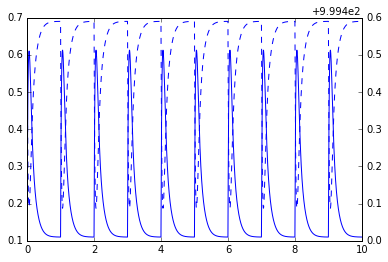

In [192]:
fig,ax=plt.subplots(1)
ax.plot(ts,ys[:,0],label="Ca cyto")

axr = plt.twinx(ax)
axr.plot(ts,ys[:,1],'b--',label="Ca SR")


### RyR release in cleft, diffusion to cytosol, sr uptake in cytosol, srcytosol to sr cleft diffusion

In [193]:
# caL->CaR diffusion
def diff(caL,caR,params):
    D = 1.
    j = -D*(caL-caR)
    return j

In [210]:
params = ip3compartment.Params()
params.pulse["amp"]=400.
params.leakSLrate = 25.
params.leakSRrate = 25.

ts = np.linspace(0,10,10000)

caSSL0=0.1 # uM 
caCyto0=0.1 # uM
caJSR0 = 1000.
caSR0 = 1000.  # uM 
y0 = [caSSL0,caCyto0,caSR0,caJSR0]

vSSLcytoRat = 0.1 # cleft to cyto volume 
vJSRSRRat = 0.1  # junctional SR to cyto-SR volume
vCleftJSRRat = 1.
vCytoSRRat = 1.
def dydt(y,t):
    caSSL,caCyto,caSR,caJSR =y
    

    ## cleft 
    dCaSSLdt_RyR = PulseRyR(caSSL,caJSR,t,params) # needs to be SR load dependent 
    dCaSSLdt_diff = 1/vSSLcytoRat  * diff(caSSL,caCyto,params)
    
    dcaSSLdt = dCaSSLdt_diff + dCaSSLdt_RyR
     
    ## Cyto 
    # Ca release into cyto
    dCaCytodt_diff = -diff(caSSL,caCyto,params)
    dCadt_SERCA = SERCA(caCyto,caSR,params)
    dCadt_leak = SLLeak(caCyto,params)
    dCast_SRleak = -SRLeak(caSR,params) 
    #print dCadt_leak
    dcaCytodt = dCaCytodt_diff + dCadt_SERCA  + dCadt_leak
    
    ## SR 
    dSRdt_leak = -dCast_SRleak*vCytoSRRat
    dSRdt_SERCA = -dCadt_SERCA*vCytoSRRat
    dcaSRdt_diff = diff(caSR,caJSR,params)

    dcaSRdt = dcaSRdt_diff + dSRdt_SERCA + dSRdt_leak   
    
    ## jSR 
    dcaJSRdt_diff = -1/vJSRSRRat *  diff(caSR,caJSR,params)
    dSRdt_RyR = -dCaSSLdt_RyR*vCleftJSRRat
    dcaJSRdt = dcaJSRdt_diff + dSRdt_RyR 
    
    dydt = [dcaSSLdt,dcaCytodt,dcaSRdt,dcaJSRdt]
    return dydt
    
ys = odeint(dydt,y0,ts)

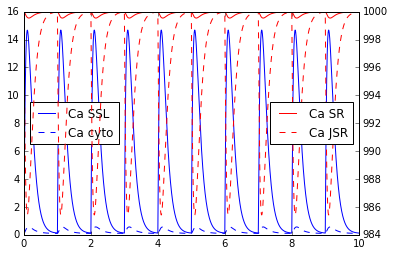

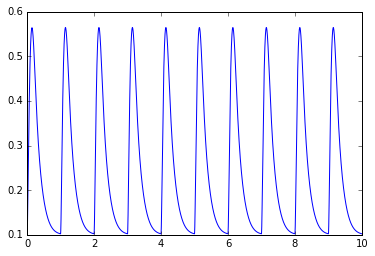

In [211]:
fig,ax=plt.subplots(1)
ax.plot(ts,ys[:,0],label="Ca SSL")
ax.plot(ts,ys[:,1],'b--',label="Ca cyto")
plt.legend(loc=0)

axr = plt.twinx(ax)
axr.plot(ts,ys[:,2],'r-',label="Ca SR")
axr.plot(ts,ys[:,3],'r--',label="Ca JSR")
plt.legend(loc=0)

plt.figure()
plt.plot(ts,ys[:,1])